# This program will train a CNN model to take an input of a trajectory pair and determine if they are the same user. This trajectory pair will be a cv-ips and ble-ips trajectories.

### Imports

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import math
from tqdm import tqdm

### Get relavant files

In [2]:
scenarios = glob.glob("data/s[1-9]?[1-9]")

### Generate cv dataframe for each scenario

In [3]:
cv_dfs = []
counter = 0
for scenario in tqdm(scenarios):
    counter += 1
    #print("Starting scenario %s (%d/%d)" % (scenario.split("/")[1], counter, len(scenarios)))
    cvData = pd.read_csv(scenario+"/data/cv_coords.csv")
    frame_dict = pd.read_csv(scenario+"/data/frame_id_to_time.csv", index_col="frame_id")
    df = pd.DataFrame()
    for frame in cvData["frame_id"].unique():
        df.loc[frame,"timestep"] = frame_dict.loc[frame, "timestep"]
        for i in range(5):
            pdf = cvData[np.logical_and(cvData["frame_id"]==frame, cvData["id"]==i)]
            if pdf.empty:
                df.loc[frame, "cv_x%d"%i] = -1
                df.loc[frame, "cv_y%d"%i] = -1
            else:
                df.loc[frame, "cv_x%d"%i] = pdf.loc[pdf.index[0], "x"]
                df.loc[frame, "cv_y%d"%i] = pdf.loc[pdf.index[0], "y"]
    df.index.name = "frame_id"
    cv_dfs.append(df)

100%|███████████████████████████████████████████| 14/14 [01:14<00:00,  5.35s/it]


### Generate ble dataframe for each scenario

In [4]:
ble_dfs = []
counter = 0
bleDict = pd.read_csv("data/ble_cluster_to_coord.csv")
for scenario in tqdm(scenarios):
    counter += 1
    #print("Starting scenario %s (%d/%d)" % (scenario.split("/")[1], counter, len(scenarios)))
    bleData = pd.read_csv(glob.glob(scenario+"/data/complete*.csv")[0])
    df = pd.DataFrame()
    for timestep in bleData["timestep"].unique():
        for i in range(5):
            pdf = bleData[np.logical_and(bleData["timestep"]==timestep, bleData["id"]==i)]
            if pdf.empty or pdf.loc[pdf.index[0], "Predicted"] == 40:
                df.loc[timestep, "ble_x%d"%i] = np.nan
                df.loc[timestep, "ble_y%d"%i] = np.nan
            else:
                df.loc[timestep, "ble_x%d"%i] = bleDict.loc[pdf.loc[pdf.index[0], "Predicted"], "x"]
                df.loc[timestep, "ble_y%d"%i] = bleDict.loc[pdf.loc[pdf.index[0], "Predicted"], "y"]
    df.index.name = "timestep"
    ble_dfs.append(df)

100%|███████████████████████████████████████████| 14/14 [00:14<00:00,  1.01s/it]


### Generate trajectory pairs

In [32]:
X_list = []
y = []
window = 15
step = 5

for scenario in tqdm(range(len(scenarios))):
    #print("Starting scenario (%d/%d)" % (scenario+1, len(scenarios)))
    # merged ble and cv dataframes in sync with timestep
    merged = pd.merge(cv_dfs[scenario].set_index("timestep"), ble_dfs[scenario], left_index=True, right_index=True).reset_index(drop=True) 

    for row in range(window, len(merged), step):  # loop through scenario and create lists of trajectory windows
        cv_trajs = []
        ble_trajs = []
        
        for user in range(len(merged.columns)//4):  # loops through each user
            user_traj = merged.filter(regex=str(user))
            
            if -1 in user_traj.values:
                continue
            
            user_traj = user_traj.dropna()  # get cv and ble data for on user, drop all nan
            temp_traj = user_traj.reset_index().sub(row)
            temp_traj = temp_traj[temp_traj["index"] > 0]  # finds the number of data points before the current time step. The first index is the number of datapoints
            if temp_traj.empty or temp_traj.index[0] < window:  # if there are not enough datapoints, no trajectory is made
                continue
                
            cv_traj = user_traj.iloc[temp_traj.index[0]-window: temp_traj.index[0], 0:2]
            ble_traj = user_traj.iloc[temp_traj.index[0]-window: temp_traj.index[0], 2:4]
            
            
            
            cv_trajs.append(cv_traj)
            ble_trajs.append(ble_traj)
            
        for i in range(len(cv_trajs)):
            for j in range(len(ble_trajs)):
                if i == j:
                    y.append(1)
                else:
                    y.append(0)
                df = pd.concat((cv_trajs[i].reset_index(drop=True), ble_trajs[j].reset_index(drop=True)), axis=1)
                df.columns = ["x1", "y1", "x2", "y2"]
                #df["distance"] = ((df["x1"]-df["x2"])**2 + (df["y1"]-df["y2"])**2).apply(np.sqrt)
                #df["diff_x"] = df["x1"].sub(df["x2"])
                #df["diff_y"] = df["y1"].sub(df["y2"])
                X_list.append(df)

100%|███████████████████████████████████████████| 14/14 [00:26<00:00,  1.87s/it]


In [33]:
# used to show class imbalance
s = [0 ,0]
for i in y:
    s[i] += 1
print(s)

[14836, 4863]


### Convert feature list to ndarray

In [34]:
X = np.ndarray((len(X_list), window, len(X_list[0].columns)))
for i in range(len(X_list)):
    X[i, :, :] = X_list[i][:] 

### Create test and train split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [36]:
X_train.shape[1:]

(15, 4)

### Create model

In [37]:
input_layer = keras.layers.Input(X_train.shape[1:])

conv1 = keras.layers.Conv1D(filters=64, kernel_size=4, padding="same")(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)


dropout = keras.layers.Dropout(.3)(conv1)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=4, padding="same")(dropout)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)




conv3 = keras.layers.Conv1D(filters=64, kernel_size=4, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.ReLU()(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

### Train model

In [38]:
#train the model
keras.utils.plot_model(model, show_shapes=True)

sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD")

epochs = 250
batch_size = 1000

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/250
15/15 [==============================] - 2s 45ms/step - loss: 0.7252 - binary_accuracy: 0.4570 - val_loss: 1.4138 - val_binary_accuracy: 0.7468 - lr: 0.0010
Epoch 2/250
15/15 [==============================] - 0s 32ms/step - loss: 0.5811 - binary_accuracy: 0.7474 - val_loss: 1.1800 - val_binary_accuracy: 0.7468 - lr: 0.0010
Epoch 3/250
15/15 [==============================] - 1s 34ms/step - loss: 0.5462 - binary_accuracy: 0.7540 - val_loss: 0.9239 - val_binary_accuracy: 0.7468 - lr: 0.0010
Epoch 4/250
15/15 [==============================] - 0s 31ms/step - loss: 0.5416 - binary_accuracy: 0.7540 - val_loss: 0.7417 - val_binary_accuracy: 0.7468 - lr: 0.0010
Epoch 5/250
15/15 [==============================] - 0s 28ms/step - loss: 0.5399 - binary_accuracy: 0.7544 - val_loss: 0.6859 - val_binary_accuracy: 0.7468 - lr: 

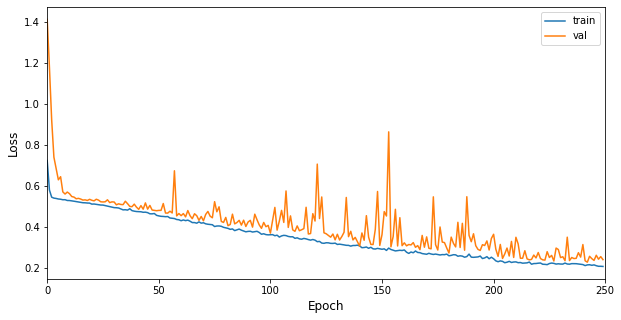

In [39]:
metric = "loss"
plt.figure(figsize=(10, 5))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.ylabel("Loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.xlim([0, len(history.history[metric])])
plt.show()
plt.close()

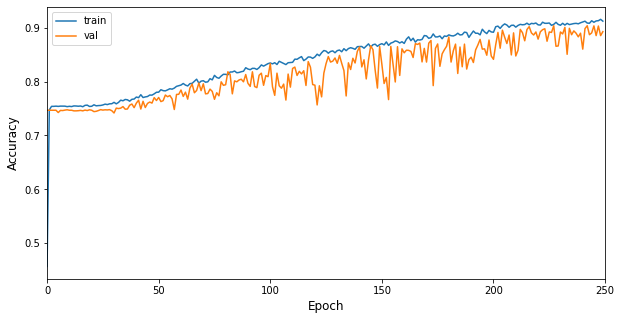

In [40]:
metric = "binary_accuracy"
plt.figure(figsize=(10, 5))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.ylabel("Accuracy", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.xlim([0, len(history.history[metric])])
plt.show()
plt.close()

In [41]:
y_pred = model.predict(X_test)

In [42]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [44]:
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
gmean = math.sqrt(tpr*tnr)

In [45]:
print(gmean)

0.8073268074847066


In [46]:
acc = accuracy_score(y_pred,y_test)
acc

0.899492385786802